In [1]:
from glob import glob
import numpy as np
import json
import pandas as pd

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline

# TODO (August 8th)
- dpi + pretty figures
- xlabel, ylabel, xlim, ylim....

# Datasets vs accuracy

In [2]:
def summarize_final_results(data='cifar10', split='test', n_last=20):
    '''
    Calculate the mean and standard deviation of results of the last 'n_last' epochs.
    '''

    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(glob('../experiments/{}*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)))
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                tmp.append(pd.DataFrame(f, index=split_list))

            tmp = pd.concat(tmp, sort=False)
            tmp_test = tmp.loc[split].iloc[:,-n_last:]
            tmp_dict = {'data': data,
                        'model': model,
                        'sample': sample,
                        'mean': tmp_test.mean().mean(),
                        'std': tmp_test.std().mean()}
            df = df.append(tmp_dict, ignore_index=True)

    return df

In [3]:
def show_summary_plot(data='cifar10'):
    df_cifar10 = summarize_final_results(data=data, n_last=20)
    if data == 'cifar10':
        x_list = np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."

    ymean = df_cifar10['mean'][df_cifar10['model']=='erm']
    yerr = df_cifar10['std'][df_cifar10['model']=='erm']
    plt.plot(x_list, ymean, marker='o', color='dodgerblue', label='ERM') 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor='dodgerblue', facecolor='dodgerblue')

    ymean = df_cifar10['mean'][df_cifar10['model']=='mixup']
    yerr = df_cifar10['std'][df_cifar10['model']=='mixup']
    plt.plot(x_list, ymean, marker='o', color='red', label='Mixup') 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor='red', facecolor='red')

    plt.legend(loc='lower right', borderaxespad=0., fontsize=13)
    plt.xlabel('$\log$(# of samples)')
    plt.title('Test accuracy: {}'.format(data))
    plt.show()
    

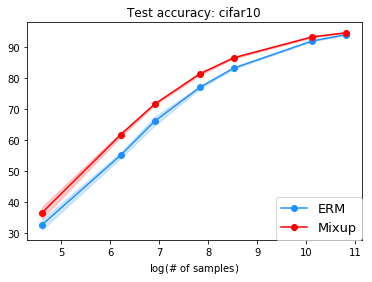

In [4]:
show_summary_plot(data='cifar10')

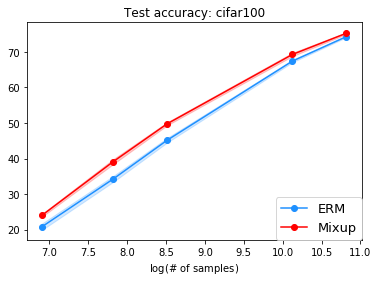

In [5]:
show_summary_plot(data='cifar100')

# Epochs vs generalization gap

In [16]:
def summarize_learning_history(data='cifar10'):

    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','maxmax0.5_']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(glob('../experiments/{}*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)))
            
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                tmp.append(pd.DataFrame(f, index=split_list))
            
            tmp = pd.concat(tmp, sort=False)
            generalization_gap = np.array(tmp.loc['tr'])-np.array(tmp.loc['test'])
            
            tmp_dict = {'data': data,
                        'model': model,
                        'sample': sample,
                       'mean': list(np.mean(generalization_gap, axis=0)),
                       'std': list(np.std(generalization_gap, axis=0))}
            df = df.append(tmp_dict, ignore_index=True)

    return df


In [8]:
def show_generalization_gap(data='cifar10', sample=50000):
    df_cifar10_history = summarize_learning_history(data=data)
    x_list = np.arange(100)

    ind = (df_cifar10_history['model']=='erm') & (df_cifar10_history['sample']==sample)
    ymean = np.array(df_cifar10_history['mean'][ind].iloc[0])
    yerr = np.array(df_cifar10_history['std'][ind].iloc[0])
    plt.plot(x_list, ymean, marker='o', color='dodgerblue', label='ERM') 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor='dodgerblue', facecolor='dodgerblue')

    ind = (df_cifar10_history['model']=='mixup') & (df_cifar10_history['sample']==sample)
    ymean = np.array(df_cifar10_history['mean'][ind].iloc[0])
    yerr = np.array(df_cifar10_history['std'][ind].iloc[0])
    plt.plot(x_list, ymean, marker='o', color='red', label='Mixup') 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor='red', facecolor='red')
    
    plt.legend(loc='lower right', borderaxespad=0., fontsize=13)
    plt.xlabel('Epochs')
    plt.title('Generalization gap {}-{}'.format(data,sample))
    plt.show()

## CIFAR10 dataset

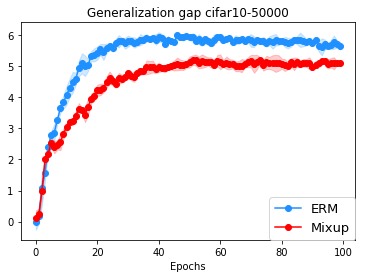

In [8]:
show_generalization_gap(data='cifar10',sample=50000)

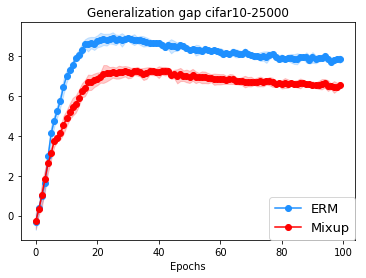

In [9]:
show_generalization_gap(data='cifar10',sample=25000)

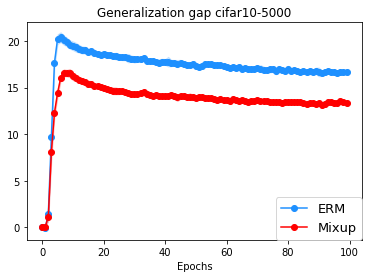

In [10]:
show_generalization_gap(data='cifar10',sample=5000)

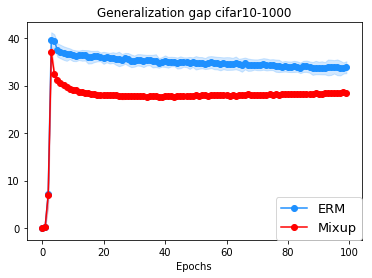

In [11]:
show_generalization_gap(data='cifar10',sample=1000)

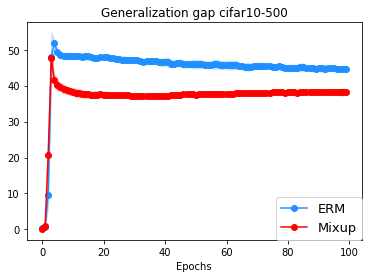

In [12]:
show_generalization_gap(data='cifar10',sample=500)

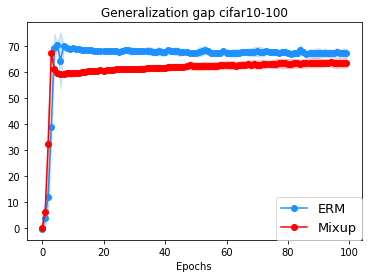

In [13]:
show_generalization_gap(data='cifar10',sample=100)

## CIFAR100 dataset

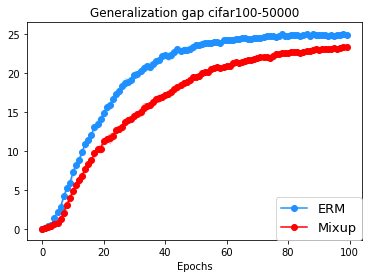

In [14]:
show_generalization_gap(data='cifar100',sample=50000)

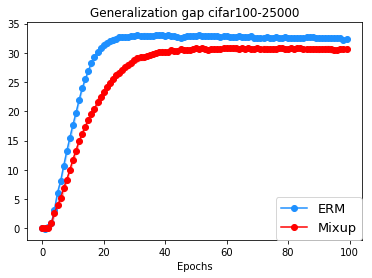

In [15]:
show_generalization_gap(data='cifar100',sample=25000)

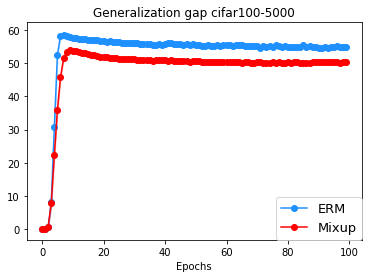

In [16]:
show_generalization_gap(data='cifar100',sample=5000)

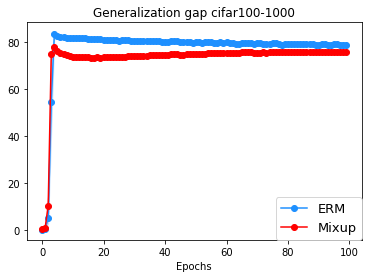

In [17]:
show_generalization_gap(data='cifar100',sample=1000)

# Epoch vs. Generalization Gap (Gradient regularization)

In [94]:
def summarize_learning_history_grad(models):
    data = 'cifar10'
    sample_sizes = [1000]
    models =  ['erm','mixup'] + models
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(glob('../experiments/{}*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)))
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                tmp.append(pd.DataFrame(f, index=split_list))
            
            tmp = pd.concat(tmp, sort=False)
            generalization_gap = np.array(tmp.loc['tr'])-np.array(tmp.loc['test'])
            tmp_dict = {'data': data,
                        'model': model,
                        'sample': sample,
                       'mean': list(np.nanmean(generalization_gap.reshape(-1,100), axis=0)),
                       'std': list(np.sqrt(np.nanvar(generalization_gap.reshape(-1,100), axis=0)))}
            df = df.append(tmp_dict, ignore_index=True)

    return df


In [96]:
def show_generalization_gap_grad(model, data='cifar10', sample=1000):
    df_cifar10_history = summarize_learning_history_grad([model])
    x_list = np.arange(100)

    ind = (df_cifar10_history['model']=='erm') & (df_cifar10_history['sample']==sample)
    ymean = np.array(df_cifar10_history['mean'][ind].iloc[0])
    yerr = np.array(df_cifar10_history['std'][ind].iloc[0])
    plt.plot(x_list, ymean, marker='o', color='dodgerblue', label='ERM') 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor='dodgerblue', facecolor='dodgerblue')

    ind = (df_cifar10_history['model']=='mixup') & (df_cifar10_history['sample']==sample)
    ymean = np.array(df_cifar10_history['mean'][ind].iloc[0])
    yerr = np.array(df_cifar10_history['std'][ind].iloc[0])
    plt.plot(x_list, ymean, marker='o', color='red', label='Mixup') 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor='red', facecolor='red')

    ind = (df_cifar10_history['model']==model) & (df_cifar10_history['sample']==sample)
    ymean = np.array(df_cifar10_history['mean'][ind].iloc[0])
    yerr = np.array(df_cifar10_history['std'][ind].iloc[0])
    plt.plot(x_list, ymean, marker='o', color='black', label=str(model)) 
    plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor='black', facecolor='red')

    
    plt.legend(loc='lower right', borderaxespad=0., fontsize=13)
    plt.xlabel('Epochs')
    plt.title('Generalization gap {}-{}'.format(data,sample))
    plt.show()

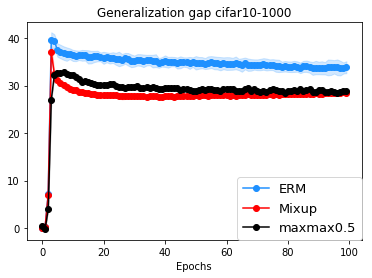

In [122]:
show_generalization_gap_grad('maxmax0.5')

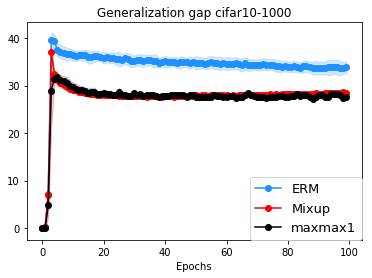

In [123]:
show_generalization_gap_grad('maxmax1')

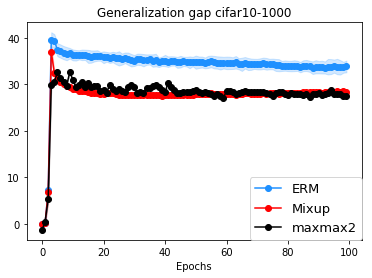

In [124]:
show_generalization_gap_grad('maxmax2')

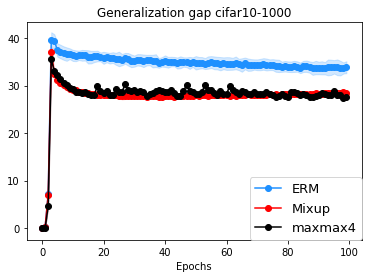

In [125]:
show_generalization_gap_grad('maxmax4')

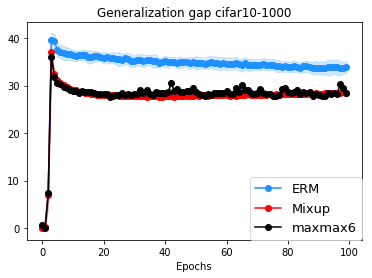

In [126]:
show_generalization_gap_grad('maxmax6')

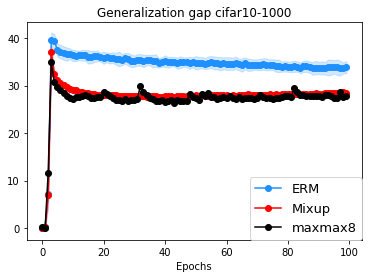

In [127]:
show_generalization_gap_grad('maxmax8')

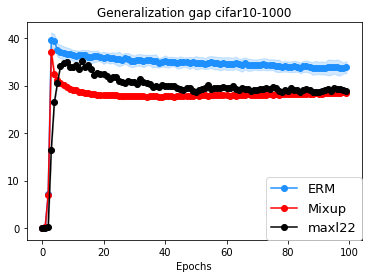

In [129]:
show_generalization_gap_grad('maxl22')

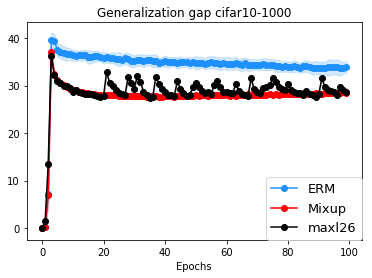

In [130]:
show_generalization_gap_grad('maxl26')

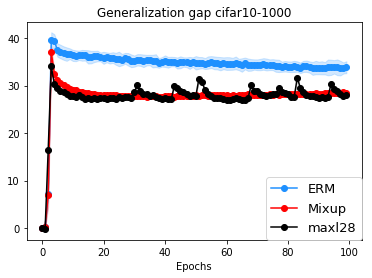

In [131]:
show_generalization_gap_grad('maxl28')

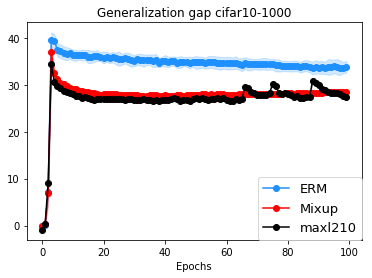

In [132]:
show_generalization_gap_grad('maxl210')

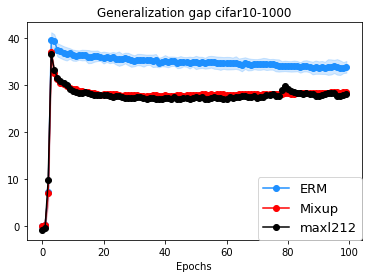

In [133]:
show_generalization_gap_grad('maxl212')

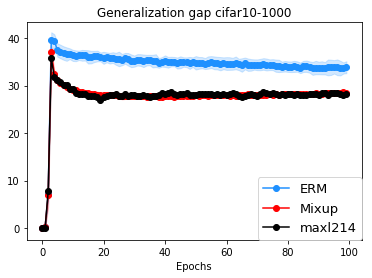

In [134]:
show_generalization_gap_grad('maxl214')

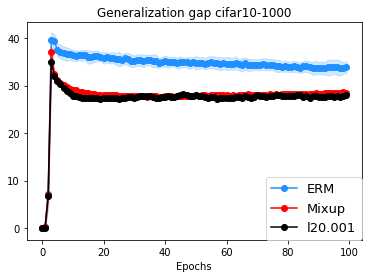

In [137]:
show_generalization_gap_grad('l20.001')

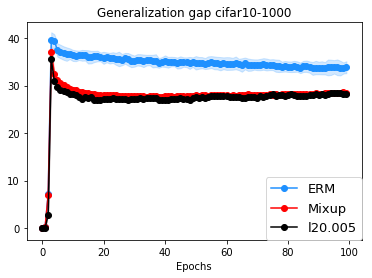

In [138]:
show_generalization_gap_grad('l20.005')

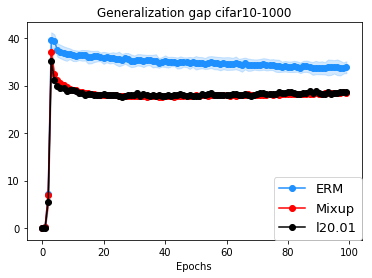

In [139]:
show_generalization_gap_grad('l20.01')

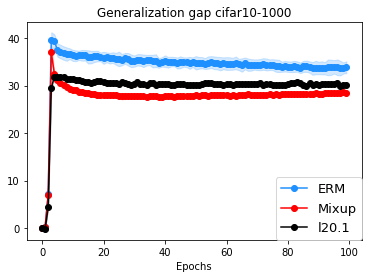

In [140]:
show_generalization_gap_grad('l20.1')